# nn-basic-conv-compare
### (topic: neural networks / machine learning)
### https://github.com/yoshc
---

### Content:
1. Building a **basic neural network** and a **convolutional neural network** for the MNIST dataset
2. Comparing their accuracy
3. Determining which images are recognized by the neural networks, and plotting them  
---

### Setting the hyperparameters of the neural networks

In [1]:
# hyperparameters of the basic neural network

# First hidden layer
NN_BASIC_LAYER_1_NUMBER_NEURONS = 200
NN_BASIC_LAYER_1_ACTIVATION = "relu" # or sigmoid?
NN_BASIC_LAYER_1_DROPOUT = 0.2
# Second hidden layer
NN_BASIC_LAYER_2_NUMBER_NEURONS = 100
NN_BASIC_LAYER_2_ACTIVATION = "relu" # or sigmoid?
NN_BASIC_LAYER_2_DROPOUT = 0.2
# Non layer specific hyperparameters
NN_BASIC_BATCH_SIZE = 128
NN_BASIC_EPOCHS = 10

# hyperparameters of the convolutional neural network

# TODO extract more hyperparameters

# Non layer specific hyperparameters
NN_CONV_BATCH_SIZE = 128
NN_CONV_EPOCHS = 5

## Needed imports
We need keras, numpy and matplotlib.
I am using the TensorFlow backend in keras

In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

/Users/josh/.virtualenvs/machinelearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Building a basic neural network and a convolutional neural network for the MNIST dataset
### 1.1 Loading and preparing the data
#### 1.1.1 Loading MNIST dataset

In [3]:
mnist = keras.datasets.mnist.load_data()

#### 1.1.2 Splitting up the data

In [4]:
(X_train, y_train), (X_test, y_test) = mnist

X is the image data, y is the label data

#### 1.1.3 Checking the shape and taking a peek into the data by visualizing it

In [5]:
print("train data shape=", X_train.shape, " train labels shape=", y_train.shape, sep="")
print("test data shape=", X_test.shape, " test labels shape=", y_test.shape, sep="")
print("This means we have have", X_train.shape[0], "train images and", X_test.shape[0], "test images")

train data shape=(60000, 28, 28) train labels shape=(60000,)
test data shape=(10000, 28, 28) test labels shape=(10000,)
This means we have have 60000 train images and 10000 test images


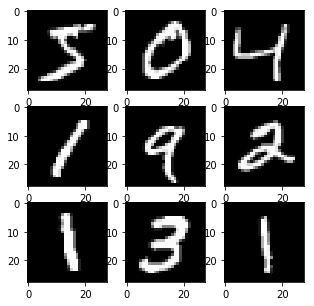

Should be [5, 0, 4, 1, 9, 2, 1, 3, 1]


In [6]:
# Visualizing the first 9 images using matplotlib
fig=plt.figure(figsize=(5, 5))
columns, rows = 3,3
for i in range(0, rows*columns):
    img = X_train[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap="gray")
plt.show()

# Verifying it
print("Should be", [label for label in y_train[:columns*rows]])

#### 1.1.4 Converting image data from [0; 255] to [0.0f, 1.0f]
Our neural network uses float values between 0.0 and 1.0, but the dataset uses integer values between 0 and 255

In [7]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

#### 1.1.5 Reshaping label data
The label data looks like [5, 0, 4, 1, 9, ...], but it has to be categorical. For example the label "5" should be represented by a float ndarray filled with zeros, except for the index 5 should be 1.0  
example: 5 -> [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]  
There is also a keras util function for that purpose but it's easy to write that function ourselves since it's trivial

In [8]:
def to_categorical(arr):
    target_shape = (len(arr), 10)
    data = np.zeros(target_shape)
    for i in range(len(arr)):
        data[i, arr[i]] = 1.0
    return data

In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# Verifying it
print(y_train[0]) # should be [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] like in the example above

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


#### 1.1.6 Reshaping data for basic neural network
The neural network input should be 1-dimensional, whereas the convolutional network takes takes the data 2-dimensional as it is.  
We basically want to reshape the input from (60000, 28, 28) to (60000, 784)

In [10]:
pixel_width, pixel_height = X_train.shape[1], X_train.shape[2]

In [11]:
pixels = X_train.shape[1] * X_train.shape[2] # mnist images are 28*28 pixels = 784 pixels

In [12]:
X_train_2dim = X_train.reshape((X_train.shape[0], pixels))
X_test_2dim = X_test.reshape((X_test.shape[0], pixels))

In [13]:
print(X_train_2dim.shape, X_test_2dim.shape)

(60000, 784) (10000, 784)


One last thing: The convolutional neural network expects rgb values instead of only gray-scale values.  
So we basically have shape (60000, 28, 28) and want (60000, 28, 28, 3)

In [14]:
print("Warning: This reshape operation might take a few seconds(/minutes?)")
# First for train data
X_train_rgb = np.zeros(shape=(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))
for i in range(len(X_train)):
    X_train_rgb[i,:,:,0] = X_train[i,:,:]
    X_train_rgb[i,:,:,1] = X_train[i,:,:]
    X_train_rgb[i,:,:,2] = X_train[i,:,:]
    if i % 10000 == 0:
        print(i, "/", len(X_train))

(60000, 28, 28, 3)
0 / 60000
10000 / 60000
20000 / 60000
30000 / 60000
40000 / 60000
50000 / 60000
Finished reshaping to rgb values


In [23]:
# Of course also for test data
X_test_rgb = np.zeros(shape=(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))
for i in range(len(X_test)):
    X_test_rgb[i,:,:,0] = X_test[i,:,:]
    X_test_rgb[i,:,:,1] = X_test[i,:,:]
    X_test_rgb[i,:,:,2] = X_test[i,:,:]
    if i % 10000 == 0:
        print(i, "/", len(X_test))
print("Finished reshaping to rgb values")

0 / 10000
Finished reshaping to rgb values


Exactly what we wanted! The data is now prepared!

### 1.2 Now the fun part: Building the neural networks

We will be building two models: one for the _basic neural network_ and one for the _convolutional neural network_

#### 1.2.1 Building the basic neural network model

In [15]:
# First model: basic neural network
model_basic = Sequential()

# Layer 1
model_basic.add(Dense(NN_BASIC_LAYER_1_NUMBER_NEURONS, input_shape=(pixels,)))
# this is why we changed the input shape for the basic neural network ^
# otherwise the shape would not be correct
model_basic.add(Activation(NN_BASIC_LAYER_1_ACTIVATION))
model_basic.add(Dropout(NN_BASIC_LAYER_1_DROPOUT))
# Layer 2
model_basic.add(Dense(NN_BASIC_LAYER_2_NUMBER_NEURONS, input_shape=(pixels,)))
model_basic.add(Activation(NN_BASIC_LAYER_2_ACTIVATION))
model_basic.add(Dropout(NN_BASIC_LAYER_2_DROPOUT))
# Output Layer (of course needs 10 neurons because we have 10 different numbers (0-9))
model_basic.add(Dense(10))
model_basic.add(Activation("softmax"))

In [16]:
# Print a summary of the basic neural network
print(model_basic.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               157000    
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
__________

#### 1.2.2 Building the convolutional neural network model

In [17]:
model_conv = Sequential()
model_conv.add(Conv2D(pixel_width * pixel_height, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=(pixel_height, pixel_width, 3)))
model_conv.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_conv.add(Conv2D(32, (5, 5), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Flatten())
model_conv.add(Dense(100, activation='relu'))
model_conv.add(Dense(10, activation='softmax'))

In [18]:
# Print a summary of the conv neural network
print(model_conv.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 784)       59584     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 784)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          627232    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               51300     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total para

#### 1.2.3 Compile both models

In [19]:
model_basic.compile(loss="categorical_crossentropy", optimizer="adam")
model_conv.compile(loss="categorical_crossentropy", optimizer="adam")

#### 1.2.4 Training the model to fit the data

_This is where the machine learning process takes place_

In [20]:
# Training the basic neural network model
model_basic.fit(X_train_2dim, y_train,
          batch_size=NN_BASIC_BATCH_SIZE, epochs=NN_BASIC_EPOCHS,
          verbose=1)

Epoch 1/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.3749
Epoch 2/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.1551
Epoch 3/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.1116
Epoch 4/10
60000/60000 [==============================] - 2s 33us/step - loss: 0.0884
Epoch 5/10
60000/60000 [==============================] - 2s 33us/step - loss: 0.0749
Epoch 6/10
60000/60000 [==============================] - 2s 33us/step - loss: 0.0654: 0s - l
Epoch 7/10
60000/60000 [==============================] - 2s 33us/step - loss: 0.0591
Epoch 8/10
60000/60000 [==============================] - 2s 33us/step - loss: 0.0518
Epoch 9/10
60000/60000 [==============================] - 2s 33us/step - loss: 0.0465
Epoch 10/10
60000/60000 [==============================] - 2s 33us/step - loss: 0.0445


In [21]:
# Training the convolutional neural network model
model_conv.fit(X_train_rgb, y_train,
          batch_size=NN_CONV_BATCH_SIZE, epochs=NN_CONV_EPOCHS,
          verbose=1)

Epoch 1/5
60000/60000 [==============================] - 827s 14ms/step - loss: 0.1496
Epoch 2/5
60000/60000 [==============================] - 808s 13ms/step - loss: 0.0433
Epoch 3/5
60000/60000 [==============================] - 796s 13ms/step - loss: 0.0302
Epoch 4/5
60000/60000 [==============================] - 806s 13ms/step - loss: 0.0231
Epoch 5/5
60000/60000 [==============================] - 798s 13ms/step - loss: 0.0188


## 2. Evaluating the accuracy of each neural network

In [25]:
score_basic = model_basic.evaluate(X_test_2dim, y_test)
score_conv = model_conv.evaluate(X_test_rgb, y_test)

accuracy_basic = 1.0 - score_basic
accuracy_conv = 1.0 - score_conv

print("Accuracy of the basic neural network:", (accuracy_basic*100), "%")
print("Accuracy of the convolutional neural network:", (accuracy_conv*100), "%")

10000/10000 [==============================] - 29s 3ms/step
Accuracy of the basic neural network: 93.8311319121509 %
Accuracy of the convolutional neural network: 96.89384039362267 %


In [26]:
pred_basic = model_basic.predict(X_test_2dim)
pred_conv = model_conv.predict(X_test_rgb)

We need a function to convert the prediction from a array of probabilities to an int value. This integer represents the number the neural network guesses

In [27]:
def pred_to_int(pred_result):
    print(type(pred_result))
    curr_max = 0.0
    max_index = -1
    for i in range(0, len(pred_result)):
        x = pred_result[i]
        if(x > curr_max):
            max_index = i
            curr_max = x
    return max_index

## 3. Determining which images are recognized by the neural networks, and plotting them

In [134]:
def visualize(which):
    output = ""
    # parameter which can either be "basic" or "conv"
    output += ("Visualizing result for " + which + " net\n")
    wrong_indices = []
    for i in range(len(y_test)):
        guess = pred_to_int(pred_basic[i] if which == "basic" else pred_conv[i])
        confidence = pred_basic[i, guess] if which == "basic" else pred_conv[i, guess]
        actual = pred_to_int(y_test[i])
        if guess != actual:
            #print("The guess of image", i, " is wrong!")
            #print("The guess is", guess, "but it actually is", actual, "(confidence=", confidence, ")")
            wrong_indices.append(i)
    fig = plt.figure(figsize=(50, 50))
    output += ("Information for the image:\n\t I means index,\n\t G means guess (what number the neural network guessed),\n\t A means actual (what the right answer would have been)\n")
    columns, rows = 25, 25
    for i in range(0, len(wrong_indices)):
        index = wrong_indices[i]
        if i > columns*rows-1:
            break
        img = X_test[index]
        subplot = fig.add_subplot(rows, columns, i+1)
        subplot.axis("off")
        plt.title("I: " + str(index) + " G: " +
                  str(pred_to_int(pred_basic[index] if which == "basic" else pred_conv[index])) +
                  " A: " + str(pred_to_int(y_test[index])))
        plt.imshow(img, cmap="gray")
    plt.savefig(("visualize-" + which), transparent=False, bbox_inches='tight', pad_inches=0)
    
    output += ("Wrong guesses: " + str(len(wrong_indices)) + " out of " + str(len(X_test)) + "\n")
    output += "Image Name:" + "visualize-" + which + ".png\n"
    output += "Please open the file in your system viewer, it might be big"
    return output

First the basic neural net  
  
**Notes:**
- "capture" and the weird output strategy is used due to a bug, which results in output spam by calling visualize()  
- visualize() might take a few seconds
- it saves a file called visualize-basic.png (and visualize-conv.png) into the current directory, which contains all images that can not be recognized by the corresponding neural network

In [135]:
%%capture capt
out = visualize("basic")

Visualizing result for basic net
Information for the image:
	 I means index,
	 G means guess (what number the neural network guessed),
	 A means actual (what the right answer would have been)
Wrong guesses: 180 out of 10000
Image Name:visualize-basic.png
Please open the file in your system viewer, it might be big


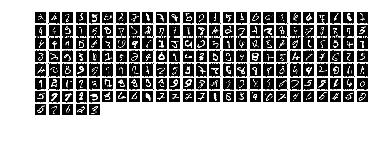

In [136]:
import matplotlib.image
print(out)
img = matplotlib.image.imread('visualize-basic.png')
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

Now the convolutional net

In [137]:
%%capture capt
out = visualize("conv")

Visualizing result for conv net
Information for the image:
	 I means index,
	 G means guess (what number the neural network guessed),
	 A means actual (what the right answer would have been)
Wrong guesses: 97 out of 10000
Image Name:visualize-conv.png
Please open the file in your system viewer, it might be big


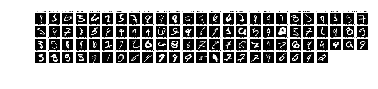

In [138]:
print(out)
img = matplotlib.image.imread('visualize-conv.png')
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()